# Model Assessment and prediction on the blind set #

In this last notebook we have loaded the best models generated to find our final model for the ml-cup-22.

In particular, we have implemented an ensembling method using the best model generated during the model selection.

These are the models that we considered:

1. Neural Network (PyTorch, trained performing a grid search)
2. Neural Network (Keras, trained performing a random search)

for each model we predicted the labels on the blind set, we summed up all the values and we averaged them.

### The model assessment was implemented through a hold out ###

In [5]:
import numpy as np

import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import keras.backend as K

import joblib

2022-12-21 10:29:55.873222: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 10:29:56.728420: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-21 10:29:56.728487: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-21 10:29:56.728493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Data normalizer ##

Save the info required to normalize the test set at the same way of the design test

In [6]:
def training_normalizer(x_data, y_data):
    
    x_cols = len(x_data[0])
    x_min_values = [None]*x_cols
    x_max_values = [None]*x_cols
    
    # save info to normalize the input of the test set
    for i in range(x_cols):
        col = x_data[:, i]
        
        max_vl = np.amax(col)
        min_vl = np.amin(col)
        
        x_min_values[i] = min_vl
        x_max_values[i] = max_vl
        
        
    y_cols = len(y_data[0])
    y_min_values = [None]*y_cols
    y_max_values = [None]*y_cols
            
    # save info to normalize the target of the test set
    for i in range(y_cols):
        col = y_data[:, i]
        
        max_vl = np.amax(col)
        min_vl = np.amin(col)
        
        y_min_values[i] = min_vl
        y_max_values[i] = max_vl
        
                
    return x_min_values, x_max_values, y_min_values, y_max_values

## Data loader ##

Load a dataset

In [7]:
def load_dataset(local_path):
    
    # Load the dataset
    data = np.loadtxt(local_path, delimiter=",", skiprows=1, usecols=range(2,13), dtype='float32')

    # divide into input and target
    x_data = (data[:, 0:9])
    y_data = (data[:, 9:11])
    
    return x_data, y_data

## Normalize input ##

Normalize the input of the test set of the internal model assessment

In [8]:
def test_normalizer(x_data_ts, x_min_values, x_max_values):
        
    x_cols = len(x_data_ts[0])
    
    # normalize the input of the test set
    for i in range(x_cols):        
        x_data_ts[:, i] = (x_data_ts[:, i] - x_min_values[i]) / (x_max_values[i] - x_min_values[i])
        
    
    return x_data_ts

## Denormalize target ##

Denormalize the predicted target of the test set

In [9]:
def test_denormalizer(y_data_ts, y_min_values, y_max_values):
    
    y_cols = len(y_data_ts[0])
    
    # denormalize the predicted target of the test set
    for i in range(y_cols):
        y_data_ts[:, i] = y_data_ts[:, i] * (y_max_values[i] - y_min_values[i]) + y_min_values[i] 
        
    return y_data_ts

## PyTorch model ##

class for the model of pytorch

In [10]:
class CupNeuralNet(nn.Module):
    # define the neural network's structure
    def __init__(self, input_size, hidden_size, num_layers, num_output):
        super(CupNeuralNet, self).__init__()
        
        self.linears = nn.ModuleList([nn.Linear(input_size, hidden_size)])
        self.linears.extend([nn.Linear(hidden_size, hidden_size) for i in range(1, num_layers)])
        self.linears.append(nn.Linear(hidden_size, num_output))
        
    # Forward pass of the neural network
    def forward(self, x):
        
        first = True
        for layer in self.linears:
            if (first):
                first = False
            else:
                x = nn.functional.relu(x)
            x = layer(x)
        return x

predict the target of the test set

In [11]:
def predict_target_design(model, design_loader):
    
    with torch.no_grad():
        
        first_iter = True
        total_labels = None
        for i, (inputs, labels) in enumerate(design_loader):

            # forward pass
            predicted_labels = model(inputs)
            
            if first_iter:
                first_iter = False
                total_labels = predicted_labels
            else:
                total_labels = torch.cat((total_labels, predicted_labels), 0)
    
    return total_labels

the class CupDataset has been used to create a valid dataset (for the ML cup) for the neural network

In [12]:
#Loading the ML cup's dataset
class CupDataset(Dataset):
    
    def __init__(self, data):
        # division between training and validation
        data_x = (data[:, 0:9])
        data_y = (data[:, 9:11])
                
        # conversion from numpy array to tensor
        self.x = torch.from_numpy(data_x)
        self.y = torch.from_numpy(data_y)
        
        # convert to float32
        self.x = self.x.to(torch.float32)
        self.y = self.y.to(torch.float32)
        
        # save the number of patterns in the training/validation set
        self.n_samples = data_x.shape[0]
        
    # return a specific tensor
    def __getitem__ (self, index):
        return self.x[index], self.y[index]
    
    # return the total number of patterns
    def __len__(self):
        return self.n_samples

Create a dataloader for the test set

In [13]:
def define_dataloaders(test_set):
        
    # create a pytorch dataset for the test set
    dataset_ts = CupDataset(test_set)
    dataloader_ts = DataLoader(dataset=test_set, batch_size=len(test_set), shuffle=False)

    
    return dataloader_ts

Compute the labels predicted by the model on the test set

In [14]:
def predict_target_design(model, test_loader):
    
    with torch.no_grad():
        
        first_iter = True
        total_labels = None
        
        start_iter = iter(test_loader)
        group = next(start_iter)
        group_x = group[:, 0:9]

        # forward pass
        predicted_labels = model(group_x)
            
        return predicted_labels

Compute the mean Euclidean error on the test set

In [15]:
def compute_mean_euclidean_distance(set1, set2):

    set1 = torch.from_numpy(set1)
    
    with torch.no_grad():

        tot_patt = len(set1)
        
        euclidean_distance = (set1 - set2).pow(2).sum(1).sqrt().sum()

        mean_euclidean_distance = euclidean_distance / tot_patt

        return mean_euclidean_distance

## Keras ##

Redefine the used metric

In [16]:
# This function computes the mean euclidean distance for Keras
def euclidean_distance(y_true, y_pred):
    """
    mean Euclidean distance error
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return (K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))) 

## Test Set ##

loading the test set and the selected models

In [17]:
# Local paths where the datasets are stored
local_path_tr = './dataset/ml_cup22/ML-CUP22-TR.csv'
local_path_ts = './dataset/ml_cup22/ML-CUP22-INTERNAL-TS.csv'
local_path_bl = './dataset/ml_cup22/ML-CUP22-TS.csv'

# Path where the model of pyTorch is stored
local_path_pyTorch = "./results/ml_cup/nn_GridSearch/avg_model/fm_mlcup.pt"

# Path where the model of keras is stored
local_path_keras = "results/ml_cup/nn_RandomSearch/avg_model_double_layer/"

# Path where the KRR model is stored
local_path_krr_1 = "results/ml_cup/KRR/rbf_krr_1.z"
local_path_krr_2 = "results/ml_cup/KRR/rbf_krr_2.z"

# loading the training set for the phase of normalization
x_data_tr, y_data_tr = load_dataset(local_path_tr)
x_min_values, x_max_values, y_min_values, y_max_values = training_normalizer(x_data_tr, y_data_tr)

x_data_ts, y_data_ts = load_dataset(local_path_ts)
x_data_ts = test_normalizer(x_data_ts, x_min_values, x_max_values)

# recreate the dataset
data_ts = np.concatenate((x_data_ts, y_data_ts), axis = 1) 

# create a valid dataloader for the test set
dataloader_ts = define_dataloaders(data_ts)

# loading the pytorch model
model_pt = torch.load(local_path_pyTorch)
model_pt.eval();

# loading the keras model
model_kr = load_model(local_path_keras, custom_objects={"euclidean_distance": euclidean_distance})

# loading the krr models
model_krr_1 = joblib.load(local_path_krr_1)
model_krr_2 = joblib.load(local_path_krr_2)

2022-12-21 10:30:10.319780: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-21 10:30:10.319798: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-21 10:30:10.319812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (carlo-Aspire-A515-52G): /proc/driver/nvidia/version does not exist
2022-12-21 10:30:10.319966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/carlo/anaconda3/lib/python3.9/site-packages/sklearn/base

## Predict labels ##

At this point we are able for the model assessment

In [18]:
# predict the result on the internal test set
pred_labels_pyTorch = predict_target_design(model_pt, dataloader_ts)
pred_labels_keras = model_kr.predict(x_data_ts)
pred_label_krr_1 = model_krr_1.predict(x_data_ts)
pred_label_krr_2 = model_krr_2.predict(x_data_ts)
pred_label_krr = np.vstack((pred_label_krr_1, pred_label_krr_2)).T

# denormalize the result 
pred_labels_pyTorch = test_denormalizer(pred_labels_pyTorch, y_min_values, y_max_values)
pred_labels_keras = test_denormalizer(pred_labels_keras, y_min_values, y_max_values)
pred_label_krr = test_denormalizer(pred_label_krr, y_min_values, y_max_values)

10/10 [==============================] - 0s 1ms/step


## Average the results ##

In [19]:
num_models = 3
pred_labels_ensembling = (pred_labels_pyTorch + pred_labels_keras + pred_label_krr) / num_models

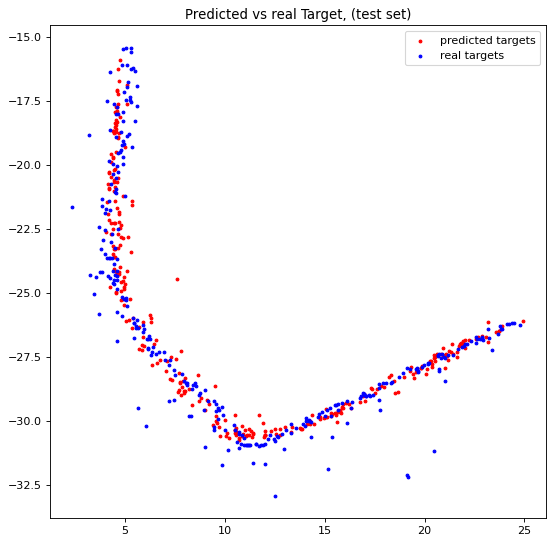

In [20]:
marker_size = 6
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(pred_labels_ensembling[:, 0], pred_labels_ensembling[:, 1], s=marker_size, c="red")
plt.scatter(y_data_ts[:, 0], y_data_ts[:, 1], s=marker_size, c="blue")

legend = ["predicted targets", "real targets"]
plt.legend(legend)

plt.title("Predicted vs real Target, (test set)")
plt.show()

Now let's see the error on the test set

In [21]:
res = compute_mean_euclidean_distance(y_data_ts, pred_labels_ensembling)

print("The mean Euclidean error of the final model is", res.item())

The mean Euclidean error of the final model is 1.411585343396038


## Blind Set ##

The last step consists in trying to predict the missing targets of the blind set

In [22]:
# load correctly the blind dataset
data_blind = np.loadtxt(local_path_bl, delimiter=",", dtype='float32')
data_blind = data_blind[:, 1:10]

# normalize the dataset
data_blind = test_normalizer(data_blind, x_min_values, x_max_values)

# create a valid dataloader for the blind set
dataloader_blind = define_dataloaders(data_blind)

# predict the result on the blind set
# pyTorch
pred_labels_blind_pyTorch = predict_target_design(model_pt, dataloader_blind)
# keras
pred_labels_blind_keras = model_kr.predict(data_blind)
# krr
pred_label_blind_krr_1 = model_krr_1.predict(data_blind)
pred_label_blind_krr_2 = model_krr_2.predict(data_blind)
pred_label_blind_krr = np.vstack((pred_label_blind_krr_1, pred_label_blind_krr_2)).T

# denormalize the results
# pyTorch
pred_labels_blind_pyTorch = test_denormalizer(pred_labels_blind_pyTorch, y_min_values, y_max_values)
# keras
pred_labels_blind_keras = test_denormalizer(pred_labels_blind_keras, y_min_values, y_max_values)
# krr
pred_label_blind_krr = test_denormalizer(pred_label_blind_krr, y_min_values, y_max_values)

17/17 [==============================] - 0s 1ms/step


In [23]:
num_models = 3
pred_labels_blind_ensembling = (pred_labels_blind_pyTorch + pred_labels_blind_keras + pred_label_blind_krr) / num_models

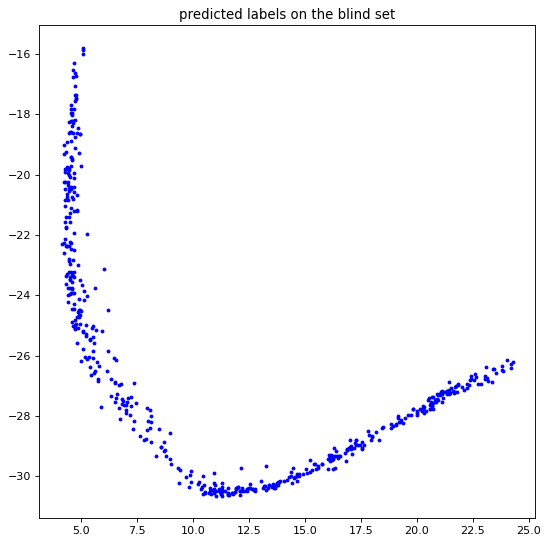

In [24]:
marker_size = 6
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(pred_labels_blind_ensembling[:, 0], pred_labels_blind_ensembling[:, 1], s=marker_size, c="blue")
plt.title("predicted labels on the blind set")
plt.show()

# Save #

Save the results 

In [25]:
# add the index
index = np.zeros((len(pred_labels_blind_ensembling), 1), dtype=int)
for i in range(len(index)):
    index[i] = i + 1
    
fin_pred_labels_blind = np.concatenate((index, pred_labels_blind_ensembling), axis=1)

# convert to pandas dataframes
df_blind = pd.DataFrame(fin_pred_labels_blind)
df_blind = df_blind.astype({0:'int'})

# local path to save the result on the blind set
local_path_blind_pred = './results/ml_cup/blind_set_prediction/F1group_ML-CUP22-TS.csv'

# open a new file and write some comments
f = open(local_path_blind_pred, 'w')

f.write('# Pasquale Esposito - Innocenzo Fulginiti - Carlo Tosoni\n')
f.write('# F1group\n')
f.write('# ML_CUP22\n')
f.write('# 5 dicembre 2022\n')

# save the dataframe as csv
df_blind.to_csv(f, header=False, index=False)

f.close()